In [1]:
# Import Libraries
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers,models
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import Model
from tensorflow.keras.layers.experimental import preprocessing
import random
import cv2
import json
from pathlib import Path
import os.path
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import itertools
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [2]:
# Create helper functions
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir, pred_and_plot

--2023-06-08 14:01:45--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-06-08 14:01:45 (34.9 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [4]:
# Load and tranform data
dataset = "../input/padangfood/dataset_padang_food"
walk_through_dir(dataset)

There are 9 directories and 0 images in '../input/padangfood/dataset_padang_food'.
There are 0 directories and 103 images in '../input/padangfood/dataset_padang_food/gulai_tambusu'.
There are 0 directories and 109 images in '../input/padangfood/dataset_padang_food/dendeng_batokok'.
There are 0 directories and 113 images in '../input/padangfood/dataset_padang_food/ayam_pop'.
There are 0 directories and 104 images in '../input/padangfood/dataset_padang_food/daging_rendang'.
There are 0 directories and 111 images in '../input/padangfood/dataset_padang_food/telur_balado'.
There are 0 directories and 116 images in '../input/padangfood/dataset_padang_food/telur_dadar'.
There are 0 directories and 107 images in '../input/padangfood/dataset_padang_food/ayam_goreng'.
There are 0 directories and 111 images in '../input/padangfood/dataset_padang_food/gulai_ikan'.
There are 0 directories and 119 images in '../input/padangfood/dataset_padang_food/gulai_tunjang'.


In [5]:
# Placing data into a Dataframe
image_dir = Path(dataset)
filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r'**/*.png')) + list(image_dir.glob(r'**/*.png'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

image_df = pd.concat([filepaths, labels], axis=1)

In [6]:
image_df

Filepath          Label
0    ../input/padangfood/dataset_padang_food/gulai_...  gulai_tambusu
1    ../input/padangfood/dataset_padang_food/gulai_...  gulai_tambusu
2    ../input/padangfood/dataset_padang_food/gulai_...  gulai_tambusu
3    ../input/padangfood/dataset_padang_food/ayam_p...       ayam_pop
4    ../input/padangfood/dataset_padang_food/ayam_p...       ayam_pop
..                                                 ...            ...
989  ../input/padangfood/dataset_padang_food/gulai_...  gulai_tunjang
990  ../input/padangfood/dataset_padang_food/gulai_...  gulai_tunjang
991  ../input/padangfood/dataset_padang_food/gulai_...  gulai_tunjang
992  ../input/padangfood/dataset_padang_food/ayam_g...    ayam_goreng
993  ../input/padangfood/dataset_padang_food/ayam_g...    ayam_goreng

[994 rows x 2 columns]

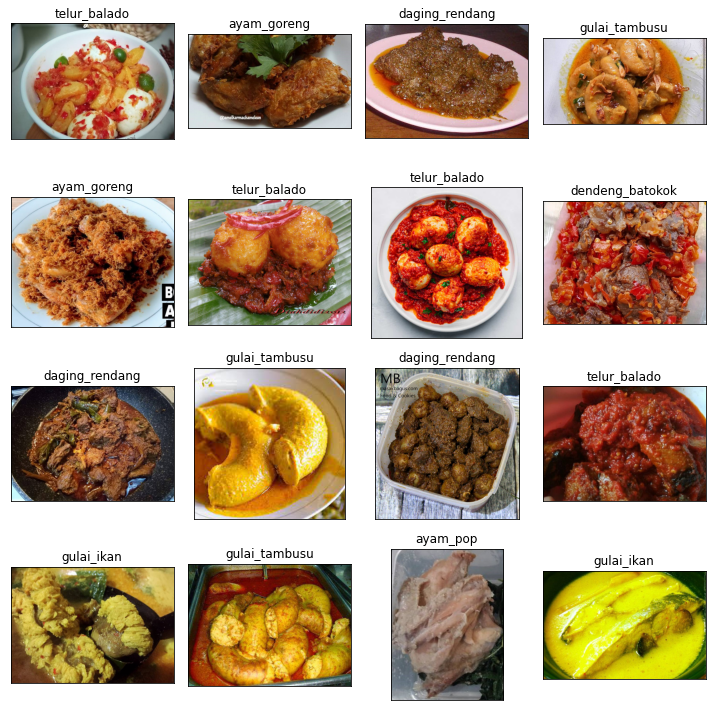

In [7]:
# Visualizing images from the dataset
random_index = np.random.randint(0, len(image_df), 16)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[random_index[i]]))
    ax.set_title(image_df.Label[random_index[i]])
plt.tight_layout()
plt.show()

In [8]:

# This function computes the Error Level Analysis (ELA) of an image
def compute_ela_cv(image_path, quality):
    # Create a temporary filename
    temp_filename = 'temp_filename.jpeg'
    
    # Define the number of scales to use
    scales = 15
    
    # Read the original image and convert it to RGB format
    original_image = cv2.imread(image_path)
    original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
    
    # Save the original image with the specified JPEG quality
    cv2.imwrite(temp_filename, original_image, [cv2.IMWRITE_JPEG_QUALITY, quality])

    # Read the compressed image
    compressed_image = cv2.imread(temp_filename)
    
    # Compute the absolute difference between the original and compressed images and multiply by the scale factor
    diff = scales * cv2.absdiff(original_image, compressed_image)
    
    # Return the computed ELA
    return diff


# This function converts an image to its ELA representation
def convert_to_ela_image(image_path, quality):
    # Create a temporary filename and a filename for the ELA image
    temp_filename = 'temp_file_name.jpeg'
    ela_filename = 'temp_ela.png'
    
    # Open the image and convert it to RGB format
    image = Image.open(image_path).convert('RGB')
    
    # Save the image with the specified JPEG quality
    image.save(temp_filename, 'JPEG', quality=quality)
    
    # Open the temporary image and compute the difference between the original and compressed images
    temp_image = Image.open(temp_filename)
    ela_image = ImageChops.difference(image, temp_image)
    
    # Compute the maximum difference between the pixels in the ELA image
    extrema = ela_image.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    
    # If the maximum difference is zero, set it to one to avoid division by zero
    if max_diff == 0:
        max_diff = 1
    
    # Scale the brightness of the ELA image by the maximum difference
    scale = 255.0 / max_diff
    ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)
    
    # Return the ELA image
    return ela_image


# This function returns a random file from a directory with the specified extension (or any file if no extension is specified)
def get_random_file(directory_path, extension=None):
    # Get a list of all files in the directory with the specified extension (or all files if no extension is specified)
    if extension:
        items = Path(directory_path).glob(f'*.{extension}')
    else:
        items = Path(directory_path).glob(f'*')
        
    # Convert the list of files to a list of strings
    items = list(items)
        
    # Choose a random file from the list and return its path as a string
    random_file = random.choice(items)
    return random_file.as_posix()

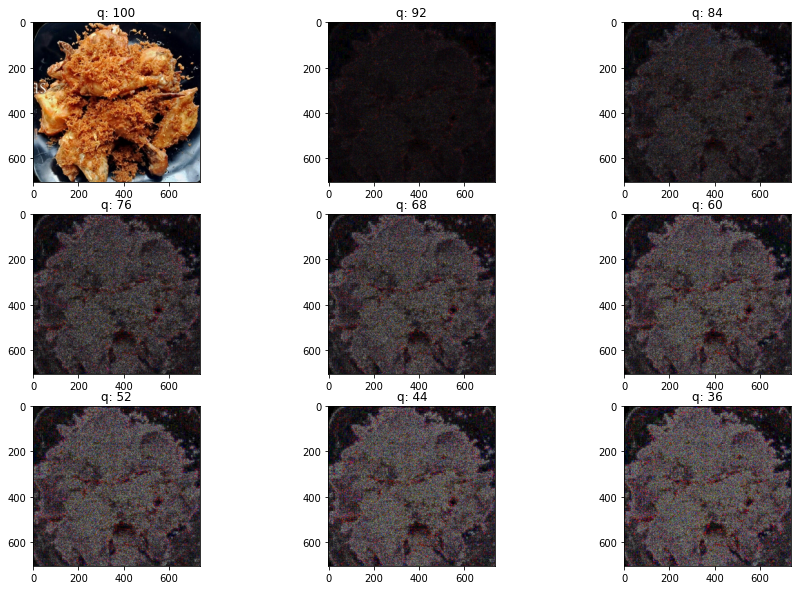

In [9]:

# Get a random image from the dataset
random_file = random.choice('../input/padangfood/dataset_padang_food/ayam_goreng')
original_image = cv2.imread(random_file)
original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB) / 255.0

# Set initial quality value and number of rows and columns for the plot
quality_init = 100
columns = 3
rows = 3

# Create a plot to display the images
fig = plt.figure(figsize=(15, 10))
for i in range(1, columns*rows +1):
    # Calculate the quality value for the current image
    quality = quality_init - (i-1) * 8
    
    # Apply the quality degradation effect to the image
    degraded_image = compute_ela_cv(path=random_file, quality=quality)
    
    # If this is the first image, display the original image instead
    if i == 1:
        degraded_image = original_image.copy()
    
    # Add the image to the plot
    ax = fig.add_subplot(rows, columns, i) 
    ax.title.set_text(f'q: {quality}')
    plt.imshow(degraded_image)
plt.show()

In [10]:
# Separate in train and test data
train_df, test_df = train_test_split(image_df, 
                                     test_size=0.2, 
                                     shuffle=True, 
                                     random_state=42)

In [11]:
train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v3.preprocess_input,
    validation_split=0.2
)

test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v3.preprocess_input
)

In [12]:
# Split the data into three categories.
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 636 validated image filenames belonging to 9 classes.
Found 159 validated image filenames belonging to 9 classes.
Found 199 validated image filenames belonging to 9 classes.


In [13]:
# Resize Layer
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(224,224),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [14]:
# Load the pretained model
pretrained_model = tf.keras.applications.MobileNetV3Large(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

17620992/17605208 [==============================] - 2s 0us/step


In [15]:
# Create checkpoint callback
checkpoint_path = "foods_classification_model_checkpoint"
checkpoint_callback = ModelCheckpoint(checkpoint_path,
                                      save_weights_only=True,
                                      monitor="val_accuracy",
                                      save_best_only=True)

# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = EarlyStopping(monitor = "val_loss", # watch the val loss metric
                               patience = 5,
                               restore_best_weights = True) # if val loss decreases for 3 epochs in a row, stop training

In [17]:
# Define the input layer of the model
input_layer = pretrained_model.input

# Resize and rescale the input images
rescaled_images = resize_and_rescale(input_layer)

# Add dense layers with ReLU activation and dropout regularization to the model
dense_layer_1 = Dense(256, activation='relu')(pretrained_model.output)
dropout_layer_1 = Dropout(0.2)(dense_layer_1)
dense_layer_2 = Dense(256, activation='relu')(dropout_layer_1)
dropout_layer_2 = Dropout(0.2)(dense_layer_2)

# Define the output layer of the model with softmax activation
output_layer = Dense(9, activation='softmax')(dropout_layer_2)

# Define the model with the input and output layers
model = Model(inputs=input_layer, outputs=output_layer)

# Compile the model with Adam optimizer, categorical crossentropy loss and accuracy metric
model.compile(
    optimizer=Adam(0.00001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model with the training and validation data, using early stopping, tensorboard and checkpoint callbacks
history = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=100,
    callbacks=[
        early_stopping,
        create_tensorboard_callback("training_logs", 
                                    "food_classification"),
        checkpoint_callback,
    ]
)

Saving TensorBoard log files to: training_logs/food_classification/20230608-140157


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 1/100
20/20 [==============================] - 24s 721ms/step - loss: 2.3025 - accuracy: 0.1053 - val_loss: 2.1745 - val_accuracy: 0.1509
Epoch 2/100
20/20 [==============================] - 7s 371ms/step - loss: 2.2612 - accuracy: 0.1478 - val_loss: 2.1294 - val_accuracy: 0.2075
Epoch 3/100
20/20 [==============================] - 7s 372ms/step - loss: 2.2129 - accuracy: 0.1509 - val_loss: 2.0891 - val_accuracy: 0.2390
Epoch 4/100
20/20 [==============================] - 7s 366ms/step - loss: 2.1483 - accuracy: 0.1918 - val_loss: 2.0496 - val_accuracy: 0.2579
Epoch 5/100
20/20 [==============================] - 8s 386ms/step - loss: 2.1258 - accuracy: 0.1871 - val_loss: 2.0116 - val_accuracy: 0.2956
Epoch 6/100
20/20 [==============================] - 7s 361ms/step - loss: 2.0543 - accuracy: 0.2516 - val_loss: 1.9741 - val_accuracy: 0.3333
Epoch 7/100
20/20 [==============================] - 8s 385ms/step - loss: 2.0346 - accuracy: 0.2642 - val_loss: 1.9363 - val_accuracy: 0.371

In [18]:
results = model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.38752
Test Accuracy: 89.45%


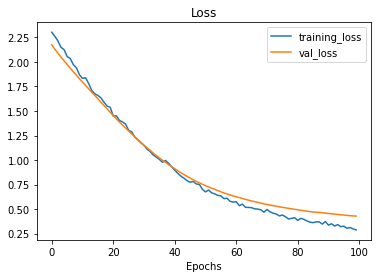

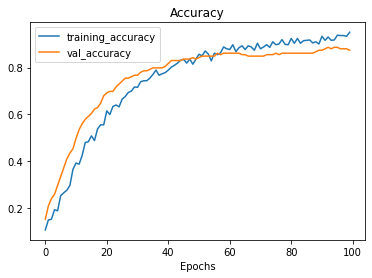

In [19]:
plot_loss_curves(history)

In [20]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 5 predictions: {pred[:5]}')

The first 5 predictions: ['gulai_tunjang', 'telur_balado', 'telur_dadar', 'telur_dadar', 'gulai_tunjang']


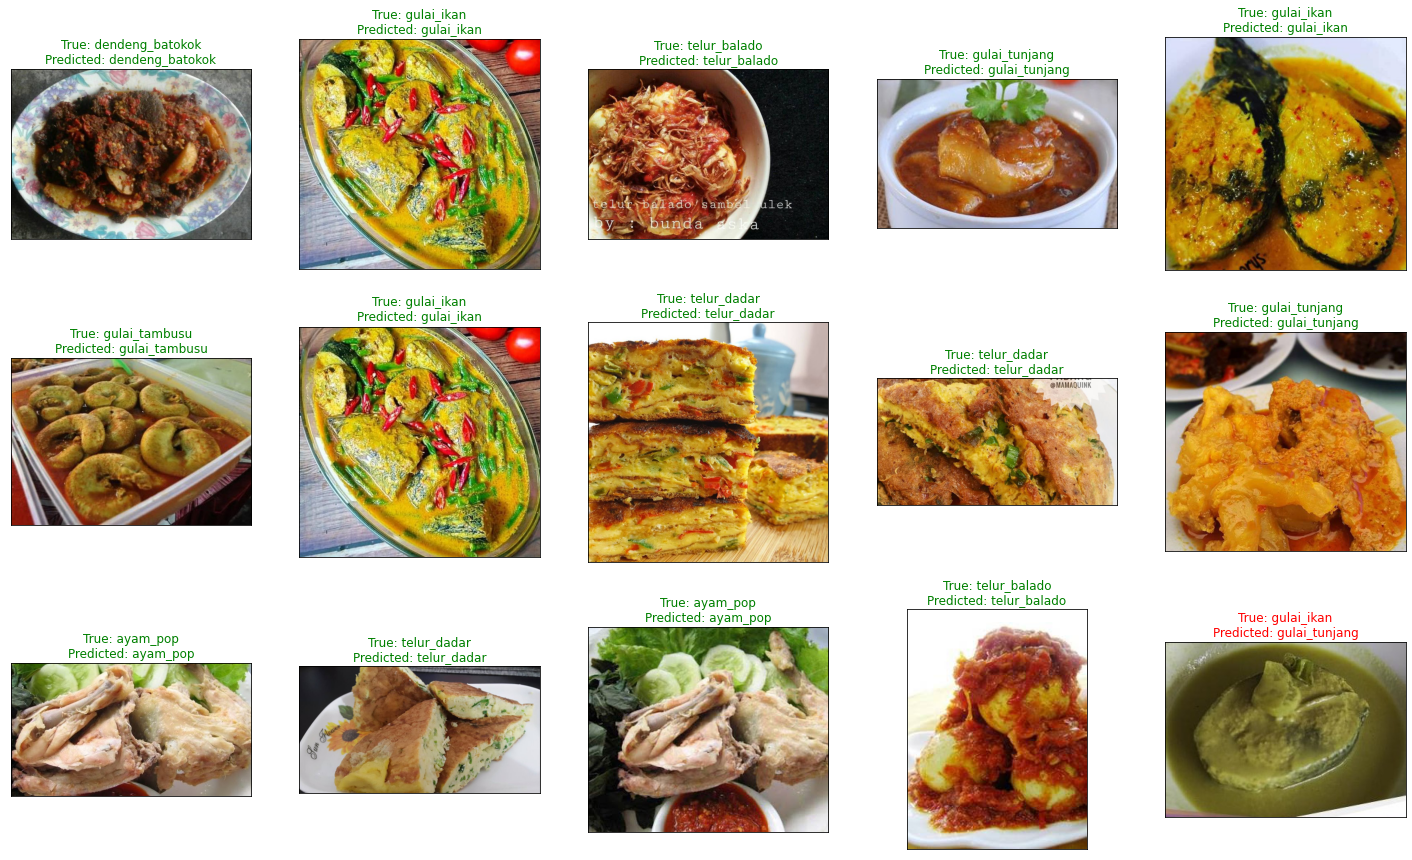

<Figure size 432x288 with 0 Axes>

In [21]:
# Display some random pictures from the dataset with their labels
random_index = np.random.randint(0, len(test_df) - 1, 15)
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(25, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[random_index[i]]))
    if test_df.Label.iloc[random_index[i]] == pred[random_index[i]]:
      color = "green"
    else:
      color = "red"
    ax.set_title(f"True: {test_df.Label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}", color=color)
plt.show()
plt.tight_layout()

In [22]:
y_test = list(test_df.Label)
print(classification_report(y_test, pred))

                 precision    recall  f1-score   support

    ayam_goreng       0.90      0.95      0.92        19
       ayam_pop       0.93      1.00      0.96        27
 daging_rendang       1.00      0.95      0.97        19
dendeng_batokok       1.00      1.00      1.00        18
     gulai_ikan       0.81      0.71      0.76        24
  gulai_tambusu       0.82      0.86      0.84        21
  gulai_tunjang       0.75      0.78      0.77        23
   telur_balado       1.00      0.88      0.94        25
    telur_dadar       0.88      0.96      0.92        23

       accuracy                           0.89       199
      macro avg       0.90      0.90      0.90       199
   weighted avg       0.90      0.89      0.89       199



In [23]:
report = classification_report(y_test, pred, output_dict=True)
df = pd.DataFrame(report).transpose()
df

precision    recall  f1-score     support
ayam_goreng       0.900000  0.947368  0.923077   19.000000
ayam_pop          0.931034  1.000000  0.964286   27.000000
daging_rendang    1.000000  0.947368  0.972973   19.000000
dendeng_batokok   1.000000  1.000000  1.000000   18.000000
gulai_ikan        0.809524  0.708333  0.755556   24.000000
gulai_tambusu     0.818182  0.857143  0.837209   21.000000
gulai_tunjang     0.750000  0.782609  0.765957   23.000000
telur_balado      1.000000  0.880000  0.936170   25.000000
telur_dadar       0.880000  0.956522  0.916667   23.000000
accuracy          0.894472  0.894472  0.894472    0.894472
macro avg         0.898749  0.897705  0.896877  199.000000
weighted avg      0.896172  0.894472  0.893869  199.000000

In [24]:
def make_confusion_matrix(y_true, 
                          y_pred, 
                          classes=None, 
                          figsize=(15, 7), 
                          text_size=10, 
                          norm=False, 
                          savefig=False): 
    
  # Create the confustion matrix
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
    n_classes = cm.shape[0] # find the number of classes we're dealing with

    # Plot the figure and make it pretty
    fig, ax = plt.subplots(figsize=figsize)
    cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
    fig.colorbar(cax)

    # Are there a list of classes?
    if classes:
        labels = classes
    else:
        labels = np.arange(cm.shape[0])
  
    # Label the axes
    ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
    # Make x-axis labels appear on bottom
    ax.xaxis.set_label_position("bottom")
    ax.xaxis.tick_bottom()
    ### Added: Rotate xticks for readability & increase font size (required due to such a large confusion matrix)
    plt.xticks(rotation=90, fontsize=text_size)
    plt.yticks(fontsize=text_size)

    # Set the threshold for different colors
    threshold = (cm.max() + cm.min()) / 2.

    # Plot the text on each cell
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if norm:
            plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
                horizontalalignment="center",
                color="white" if cm[i, j] > threshold else "black",
                size=text_size)
        else:
            plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
    if savefig:
        fig.savefig("confusion_matrix.png")


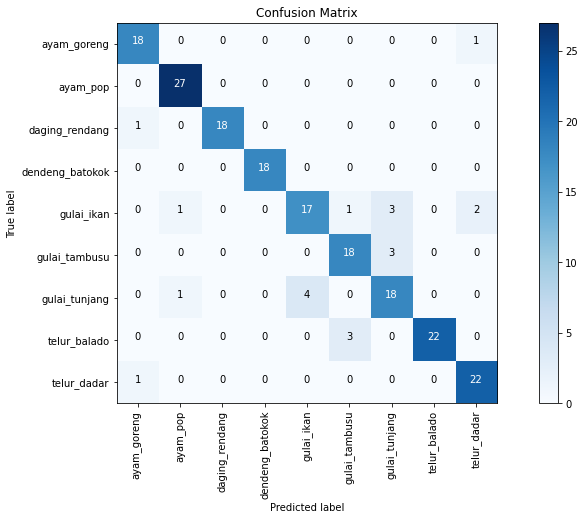

In [25]:
make_confusion_matrix(y_test, pred, list(labels.values()))

In [26]:
def get_img_array(img_path, size):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=size)
    array = tf.keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size "size"
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = tf.keras.preprocessing.image.load_img(img_path)
    img = tf.keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)
    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
#     display(Image(cam_path))
    
    return cam_path
    

preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
decode_predictions = tf.keras.applications.mobilenet_v2.decode_predictions

last_conv_layer_name = "Conv_1"
img_size = (224,224, 3)

# Remove last layer's softmax
model.layers[-1].activation = None

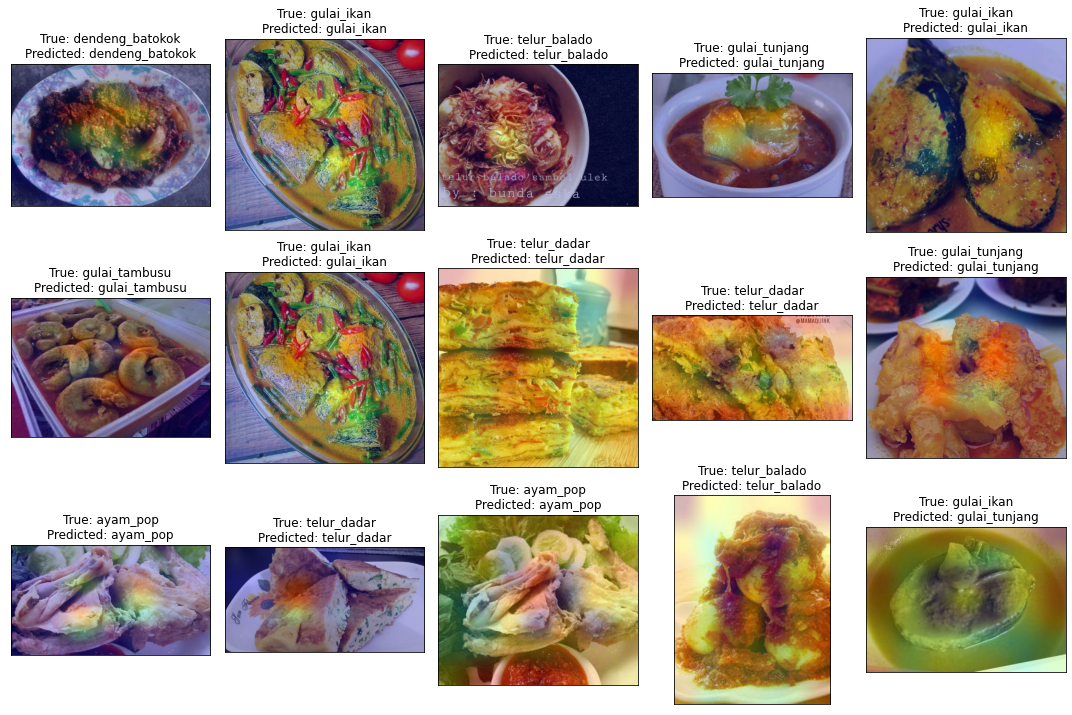

In [27]:
# Display the part of the pictures used by the neural network to classify the pictures
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    img_path = test_df.Filepath.iloc[random_index[i]]
    img_array = preprocess_input(get_img_array(img_path, size=img_size))
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
    cam_path = save_and_display_gradcam(img_path, heatmap)
    ax.imshow(plt.imread(cam_path))
    ax.set_title(f"True: {test_df.Label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}")
plt.tight_layout()
plt.show()

In [28]:
#Save the trained model as a Keras HDF5 file. 

saved_model_path = "./my_model.h5"
model.save(saved_model_path)

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [29]:
!pip install tensorflowjs

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.1/85.1 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.1/85.1 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.1/85.1 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.1/226.1 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.5/16.5 MB 33.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.9/40.9 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 588.3/588.3 MB 1.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.2/226.2 kB 22.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.0/216.0 kB 19.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 4.4 MB/s eta 0:00:0000:0100:010m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 214.2/214.2 kB 19.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.1/210.1 kB 22.0 MB/s eta 0:00:00
   

In [31]:
model = tf.keras.models.load_model('my_model.h5')
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
open("converted_model.tflite", "wb").write(tflite_model)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unable to locate the source code of <function trace_model_call.<locals>._wrapped_model at 0x7ee30419bd40>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


18399288